In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy
import datapane as dp

# 0. Dataset Description

This dataset contains historic data for the daily ten minute closing auction on the NASDAQ stock exchange.\
The purpose of this study is to review, primary analyze and identify features of the data set. It does not claim to be a complete exploratory data analysis, but perhaps suggests ways for further study.\
The source of data and the formulation of the further forecasting problem can be found at https://www.kaggle.com/competitions/optiver-trading-at-the-close/data \
Brief description of the dataset:

stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.\
date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.\
imbalance_size - The amount unmatched at the current reference price (in USD).\
imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
   - buy-side imbalance; 1
   - sell-side imbalance; -1
   - no imbalance; 0

reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.\
matched_size - The amount that can be matched at the current reference price (in USD).\
far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.\
near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.\
[bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.\
[bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.\
wap - The weighted average price in the non-auction book.

wap:
$$
\frac{ {BidPrice * AskSize + AskPrice * BidSize}}{BidSize + AskSize}
$$

seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.
   - The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
   - The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
   - Where t is the time at the current observation, we can define the target:

Target:
$$
Target = (\frac{StockWAP_{t+60}}{StockWAP_{t}} - \frac{IndexWAP_{t+60}}{IndexWAP_{t}}) * 10000
$$

# 1. Dataset anlysis and data cleaning

In [23]:
df = pd.read_csv('train.csv')
df

stock_id  date_id  seconds_in_bucket  imbalance_size  \
0               0        0                  0      3180602.69   
1               1        0                  0       166603.91   
2               2        0                  0       302879.87   
3               3        0                  0     11917682.27   
4               4        0                  0       447549.96   
...           ...      ...                ...             ...   
5237975       195      480                540      2440722.89   
5237976       196      480                540       349510.47   
5237977       197      480                540            0.00   
5237978       198      480                540      1000898.84   
5237979       199      480                540      1884285.71   

         imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                              1         0.999812   13380276.64        NaN   
1                             -1         0.999896    1642214.25        NaN   
2                             -1         0.999561    1819368.03        NaN   
3                             -1         1.000171   18389745.62        NaN   
4                             -1         0.999532   17860614.95        NaN   
...                          ...              ...           ...        ...   
5237975                       -1         1.000317   28280361.74   0.999734   
5237976                       -1         1.000643    9187699.11   1.000129   
5237977                        0         0.995789   12725436.10   0.995789   
5237978                        1         0.999210   94773271.05   0.999210   
5237979                       -1         1.002129   24073677.32   1.000859   

         near_price  bid_price   bid_size  ask_price   ask_size       wap  \
0               NaN   0.999812   60651.50   1.000026    8493.03  1.000000   
1               NaN   0.999896    3233.04   1.000660   20605.09  1.000000   
2               NaN   0.999403   37956.00   1.000298   18995.00  1.000000   
3               NaN   0.999999    2324.90   1.000214  479032.40  1.000000   
4               NaN   0.999394   16485.54   1.000016     434.10  1.000000   
...             ...        ...        ...        ...        ...       ...   
5237975    0.999734   1.000317   32257.04   1.000434  319862.40  1.000328   
5237976    1.000386   1.000643  205108.40   1.000900   93393.07  1.000819   
5237977    0.995789   0.995789   16790.66   0.995883  180038.32  0.995797   
5237978    0.999210   0.998970  125631.72   0.999210  669893.00  0.999008   
5237979    1.001494   1.002129  250081.44   1.002447  300167.56  1.002274   

           target  time_id       row_id  
0       -3.029704        0        0_0_0  
1       -5.519986        0        0_0_1  
2       -8.389950        0        0_0_2  
3       -4.010200        0        0_0_3  
4       -7.349849        0        0_0_4  
...           ...      ...          ...  
5237975  2.310276    26454  480_540_195  
5237976 -8.220077    26454  480_540_196  
5237977  1.169443    26454  480_540_197  
5237978 -1.540184    26454  480_540_198  
5237979 -6.530285    26454  480_540_199  

[5237980 rows x 17 columns]

In [11]:
df_info = df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   stock_id                 5237980 non-null  int64  
 1   date_id                  5237980 non-null  int64  
 2   seconds_in_bucket        5237980 non-null  int64  
 3   imbalance_size           5237760 non-null  float64
 4   imbalance_buy_sell_flag  5237980 non-null  int64  
 5   reference_price          5237760 non-null  float64
 6   matched_size             5237760 non-null  float64
 7   far_price                2343638 non-null  float64
 8   near_price               2380800 non-null  float64
 9   bid_price                5237760 non-null  float64
 10  bid_size                 5237980 non-null  float64
 11  ask_price                5237760 non-null  float64
 12  ask_size                 5237980 non-null  float64
 13  wap                      5237760 non-null 

In [8]:
def null_scaner(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 12))
    
    colours = ['blue', 'yellow']
    sns.heatmap(data.isna(),
                cmap=sns.color_palette(colours),
                cbar=False,
                yticklabels=False,
                ax=ax1
               )
    
    nulls_per_col = data.isna().sum() / len(data)
    nulls_per_col.plot(kind='bar',
                       x=nulls_per_col.index,
                       y=nulls_per_col.values,
                       color='yellow',
                       edgecolor='black',
                       width=1,
                       align='edge',
                       ax=ax2
                      )
    
    fig.tight_layout()

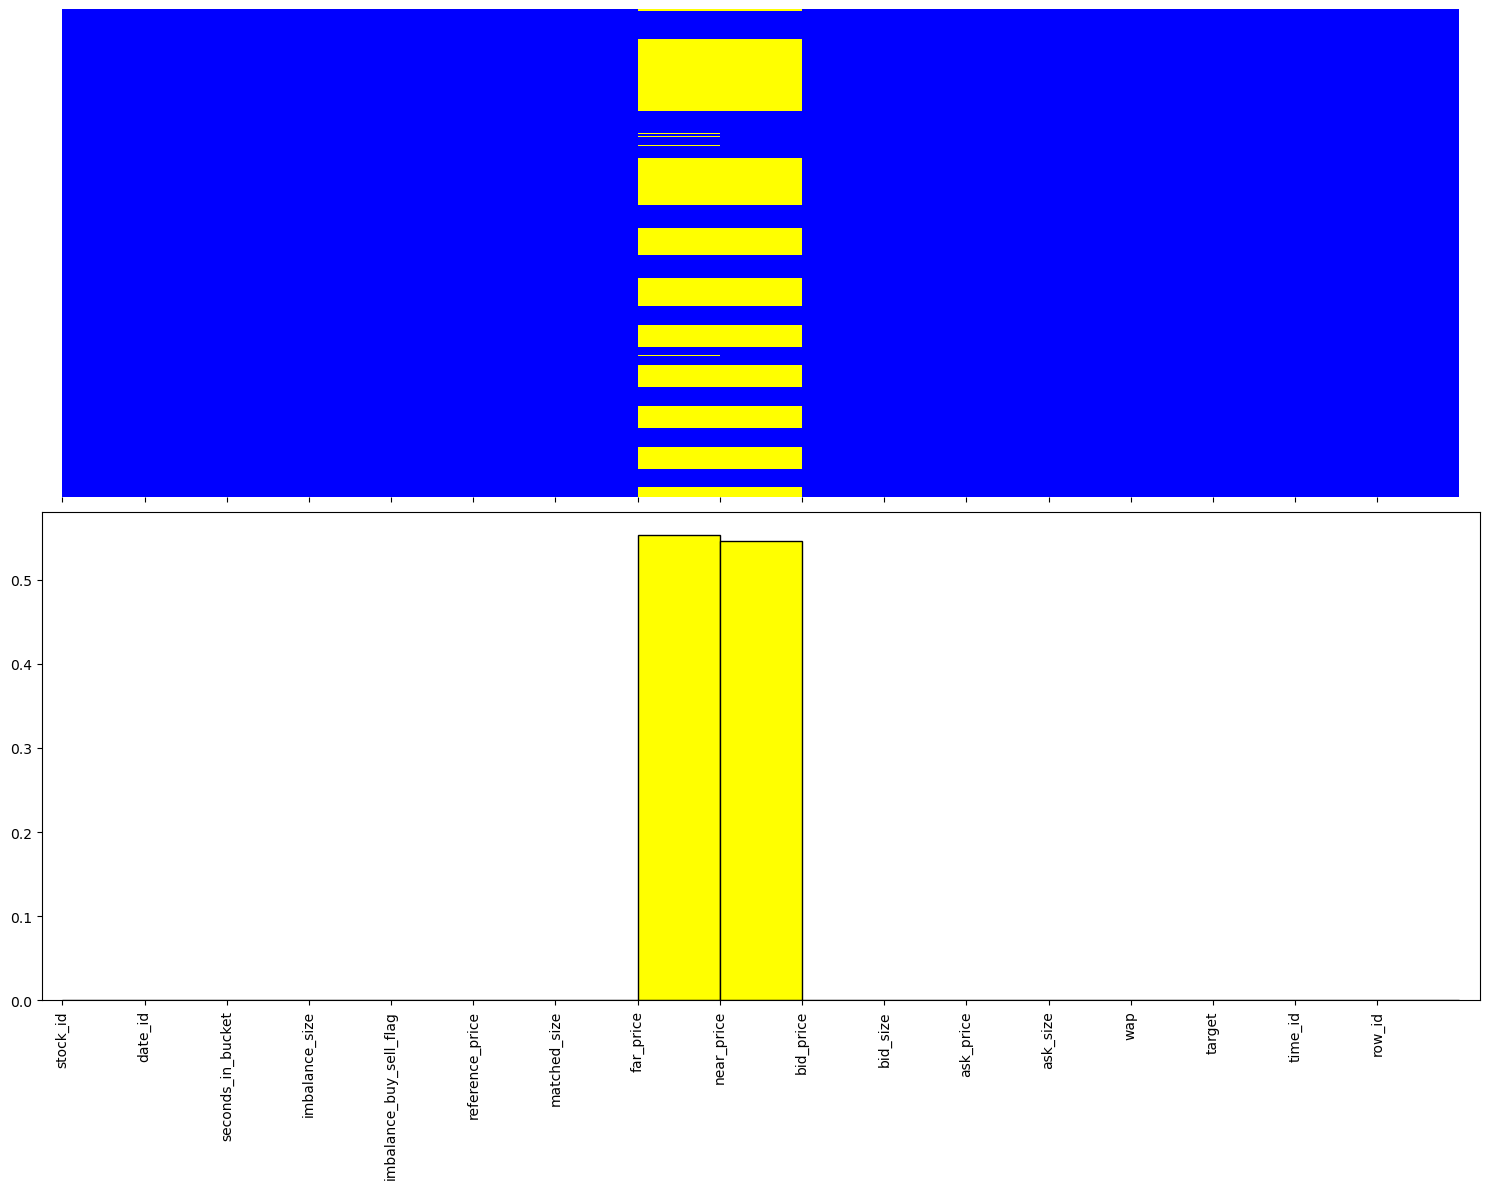

In [9]:
null_scaner_df = null_scaner(df)

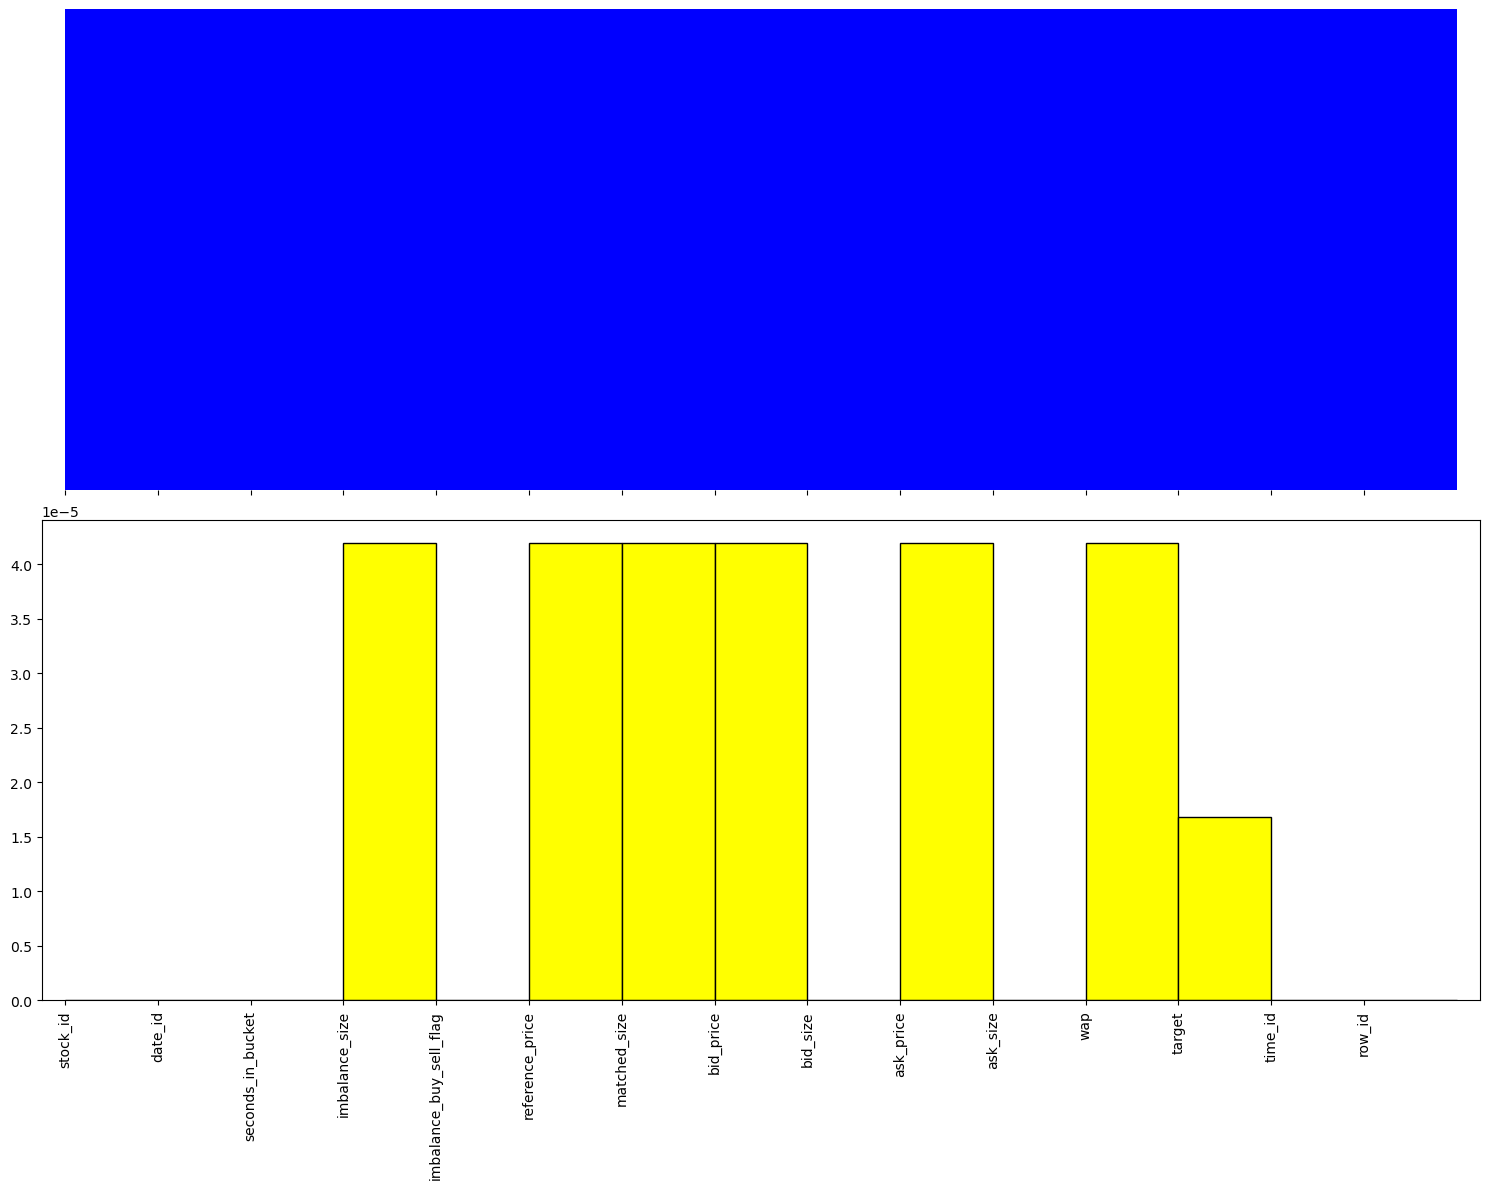

In [10]:
null_scaner_droped = null_scaner(df.drop(['far_price', 'near_price'], axis=1))

# 2. Statistical characteristics and features

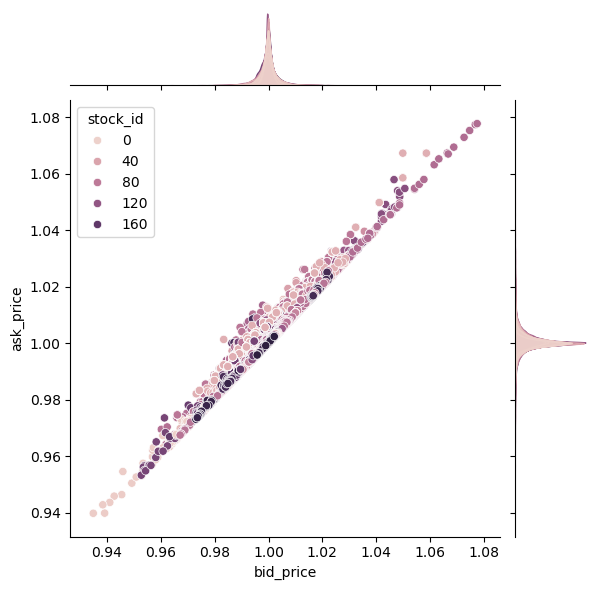

In [7]:
sns.jointplot(data=df, x='bid_price', y='ask_price', hue='stock_id')

In [3]:
ser_skew = pd.Series(np.float64) #dtype=object
for i in range(200):
    skew = df[df.stock_id==i].loc[:, 'target'].skew()
    ser_skew.at[i] = skew
print('Min-skew=%.5f, Median-skew=%.5f, Max-skew=%.5f' % (ser_skew.min(), ser_skew.median(), ser_skew.max()))

Min-skew=-8.58188, Median-skew=-0.00941, Max-skew=7.59506


In [4]:
def median_up_index(ser):
    ser_up_median = ser[ ser.astype('float64').round(5).sort_values(ignore_index=False)==
         ser.astype('float64').round(5).sort_values(ignore_index=True)
         [int(len(ser)/2)] ] # value of trimmed mid-range upper median index
    return(int(str(ser_up_median).split()[0]))

In [87]:
print('Min-skew-index=%.0f, Median-skew-index=%.0f, Max-skew-index=%.0f' % 
      (ser_skew.astype(dtype="float64").idxmin(), 
       median_up_index(ser_skew), 
       ser_skew.astype(dtype="float64").idxmax()))

Min-skew-index=142, Median-skew-index=58, Max-skew-index=56


In [11]:
stat, p = scipy.stats.shapiro(df[df.stock_id==0].loc[:, 'target']) # Shapiro-Wilk test 
print('Statistics=%.3f, p-value=%.7f' % (stat, p))

Statistics=0.956, p-value=0.0000000


C:\Work\Anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [12]:
stat, p = scipy.stats.normaltest(df[df.stock_id==0].loc[:, 'target']) # Pearson's chi-squared test / Критерий согласия Пирсона
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=3935.053, p-value=0.000


# 3. Visualize conclusions

C:\Users\botnu\AppData\Local\Temp\ipykernel_33768\3645919353.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[:, 'target'], ax=ax1, kde=False, bins=20000, norm_hist=True)
C:\Users\botnu\AppData\Local\Temp\ipykernel_33768\3645919353.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df

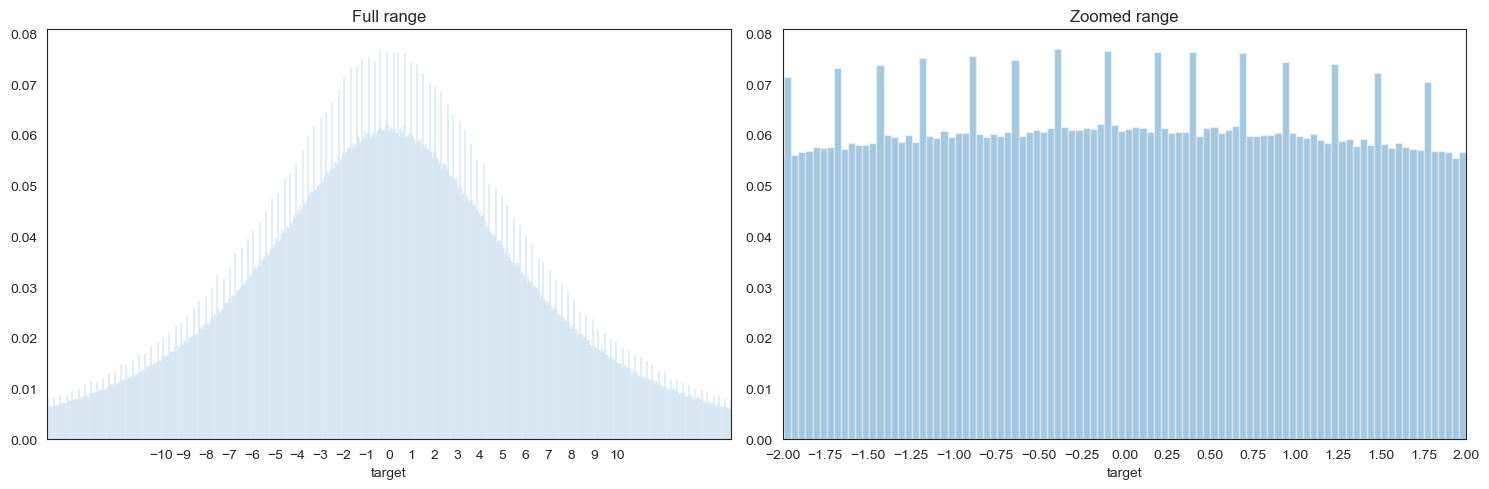

In [13]:
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.distplot(df.loc[:, 'target'], ax=ax1, kde=False, bins=20000, norm_hist=True)
ax1.set_title('Full range')
ax1.set_xticks(np.arange(-10, 10.1))
ax1.set_xlim([-15, 15])

sns.distplot(df.loc[:, 'target'], ax=ax2, kde=False, bins=20000, norm_hist=True) # displot hue_norm='Normalize')  
ax2.set_title('Zoomed range')
ax2.set_xticks(np.arange(-2, 2.1, .25))
ax2.set_xlim([-2, 2])

fig.tight_layout()

There is periodicity in the deviation Target values of wap stock prices from the index.
The nature of the deviation may be the subject of further study.

C:\Users\botnu\AppData\Local\Temp\ipykernel_33768\3329946419.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df.stock_id==stock_no].loc[:, 'target'], kde=True, bins=100, norm_hist=True)


For stock with Median-skew-index Skew=-0.009


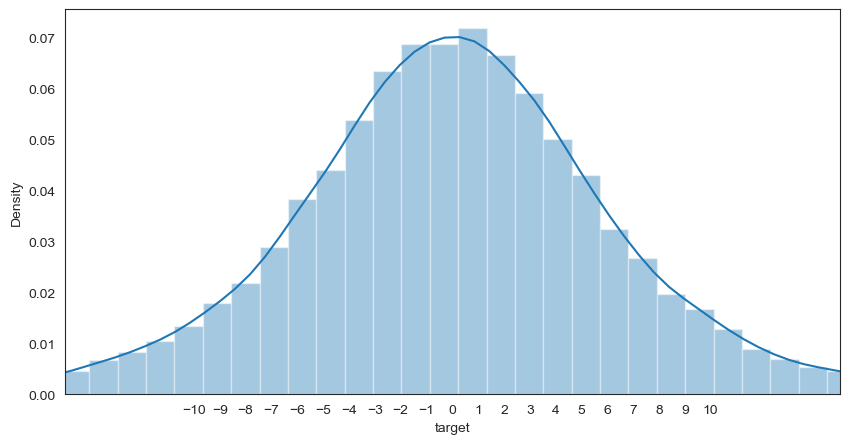

In [14]:
stock_no = median_up_index(ser_skew)
sns.set_style('white')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.set_xlim([-15, 15])
plt.xticks(np.arange(-10, 10.1, 1))
plt.xlabel('"target" deviation')
sns.distplot(df[df.stock_id==stock_no].loc[:, 'target'], kde=True, bins=100, norm_hist=True)

skew = df[df.stock_id==stock_no].loc[:, 'target'].skew()
print('For stock with Median-skew-index Skew=%.3f' % (skew))

In [89]:
train = df.groupby(['stock_id', 'date_id']).agg({'wap': ['min', 'max']}).reset_index() # m.b.'reference_price'
train.columns = train.columns.map('_'.join)
train['wap_ave'] = (train.wap_min+train.wap_max)/2
train

stock_id_  date_id_   wap_min   wap_max   wap_ave
0              0         0  0.998848  1.000517  0.999683
1              0         1  0.998045  1.000000  0.999022
2              0         2  0.998261  1.000000  0.999130
3              0         3  0.997332  1.000000  0.998666
4              0         4  0.999499  1.002788  1.001143
...          ...       ...       ...       ...       ...
95231        199       476  0.999250  1.002075  1.000663
95232        199       477  0.995854  1.000141  0.997997
95233        199       478  0.999897  1.001618  1.000757
95234        199       479  0.999756  1.004259  1.002007
95235        199       480  1.000000  1.002974  1.001487

[95236 rows x 5 columns]

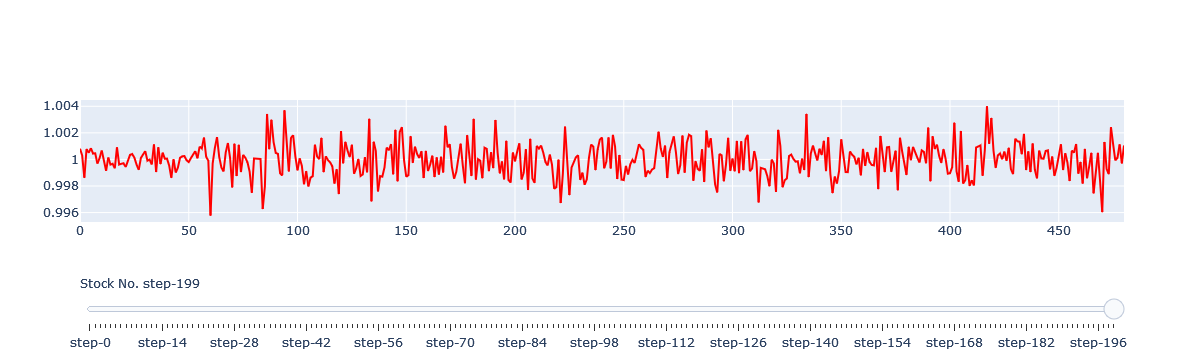

In [92]:
# Create figure
fig = go.Figure()

# Add traces, one for each slider step - stock_id
for stock in np.arange(200):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="red", width=2),
            name="stock = " + str(stock),
            x=np.arange(len(train[train.stock_id_==stock])),
            y=train[train.stock_id_==stock].wap_ave
        ))

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
stocks = []
for i in range(len(fig.data)):
    stock = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to stock: " + str(i)}],  # layout attribute
    )
    stock["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    stocks.append(stock)

slider = [dict(
    active=199,
    currentvalue={"prefix": "Stock No. "},
    pad={"t": 50},
    steps=stocks
)]

fig.update_layout(
    sliders=slider
)

fig.show()

In [36]:
# All seconds_in_bucket
wap_all = df.wap[df.stock_id==199].reset_index().drop('index', axis=1)
wap_all.rename(columns={"wap": "wap_all"})

wap_all
0      1.000000
1      0.998982
2      0.998291
3      0.997896
4      0.997736
...         ...
21610  1.002835
21611  1.002974
21612  1.001982
21613  1.001993
21614  1.002274

[21615 rows x 1 columns]

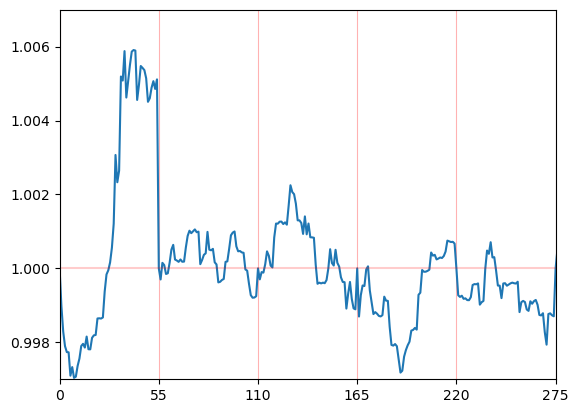

In [84]:
tick_lim = 275
ax = plt.subplot(1, 1, 1)
ax.set_xlim([0, tick_lim])
ax.set_ylim(0.997,1.007)
plt.plot(wap_all)
plt.xticks(np.arange(0, tick_lim+.1, 55))
ax.grid( axis='x', color='red', alpha=0.3)
plt.axhline(y=1, c='red', alpha=0.2)

In [28]:
wap_day = df.wap[(df.date_id==88) & (df.stock_id==199)].reset_index().drop('index', axis=1)
wap_day.rename(columns={"wap": "wap_day"})

wap_day
0   1.000000
1   0.998982
2   0.998291
3   0.997896
4   0.997736
5   0.997730
6   0.997098
7   0.997330
8   0.997039
9   0.997069
10  0.997363
11  0.997561
12  0.997899
13  0.997959
14  0.997858
15  0.998155
16  0.997813
17  0.997810
18  0.998122
19  0.998189
20  0.998199
21  0.998645
22  0.998650
23  0.998643
24  0.998673
25  0.999374
26  0.999836
27  0.999949
28  1.000163
29  1.000560
30  1.001210
31  1.003069
32  1.002331
33  1.002643
34  1.005193
35  1.005082
36  1.005879
37  1.004623
38  1.005069
39  1.005502
40  1.005865
41  1.005908
42  1.005894
43  1.004558
44  1.004966
45  1.005476
46  1.005424
47  1.005365
48  1.005144
49  1.004507
50  1.004603
51  1.004890
52  1.005066
53  1.004855
54  1.005114

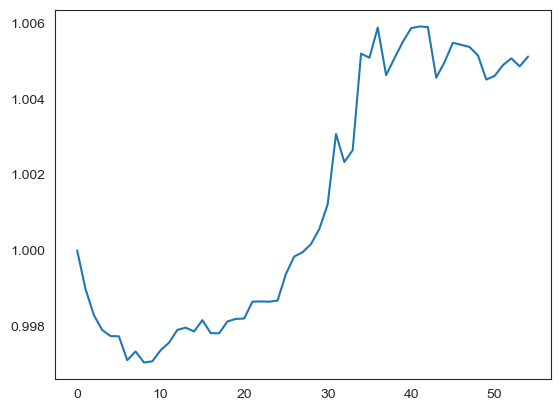

In [20]:
plt.subplot(1, 1, 1)
plt.plot(day)

# 4. Datapane report

- With the exception of the far_price and near_price fields, the number of NaN values in the remaining fields is statistically small, one thousandth of a percent of the total number of records.
- Not all stocks have the same number of days in price history 480. For example, no.79 - 300 days, 102 - 186, 135 - 290, 153 - 411, 199 - 393.
- Weighted average price wap of securities are presented in the form of normalized values. The first value for the selected day is taken as 1 and then all 10 second ticks are given relative to it. For the next day, everything is repeated again starting from 1.
- There is asymmetry in Target values for different securities (200 items), which indicates the presence of possible trends:\
    Min-skew=-8.58188, Median-skew=-0.00941, Max-skew=7.59506\
    Min-skew-index=142, Median-skew-index=58, Max-skew-index=56
- There is no reason to assume that Target values, whose future value is to be predicted, have a normal distribution.
- The distribution has the form characteristic of financial instruments with Fat-Tailed probability distributions.
- The histogram of all Target values for all time and for all securities has some periodic comb superimposed on the bell-shaped distribution.
- This periodicity indicates the presence among securities of those whose Target values more often fall into periodic bins. As the bin size increases, this effect is smoothed out due to averaging. For individual securities this deviation is not noticeable.
- This effect can possibly be used to increase the probability of predicting the Target value. Further research can be supplemented in the following areas:
    - select those bins that stand out significantly in the distribution histogram and see which securities fall into them more often, forming a pattern.
    - find out whether the comb is strictly periodic, for this we can try to apply the discrete Fourier transform to the envelope of the final histogram.

In [24]:
subject_of_study = '''Subject of study'''

dataset_anlysis_and_data_cleaning = '''Dataset anlysis and data cleaning'''

statistical_characteristics_and_features = '''Statistical characteristics and features'''

visualize_conclusions = '''Visualize conclusions'''

In [2]:

report = dp.App(
'''
    dp.Page(
        dp.Text('# Dataset Description'),
        dp.Group(
            dp.Text(subject_of_study),
            dp.Media('train.ticks.png', caption='Optiver - Trading at the Close'),
            columns=2
        ),
        dp.DataTable(df),
        title='Overlook'
    ),

    dp.Page(
        dp.Text('# Dataset anlysis and data cleaning'),
        dp.Plot(null_scaner_df),
        dp.Plot(null_scaner_droped),
        dp.Toggle(
            blocks=[
                dp.Group(
                    dataset_anlysis_and_data_cleaning,
                    dp.Table(df_info),
                    valign='center',
                    columns=2
                )
            ],
            label='Data quality'
        ),
        title='Dataset clarity'
    )
    
'''  
)

In [3]:
report.save('optiver.html')

App saved to ./optiver.html